In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.constants
from pynufft import NUFFT

mm = 1E-3
C = scipy.constants.c

def set_font(fontsize=18, font="Times New Roman"):
    rc = {"font.size" : fontsize,
    "font.family" : font,
    "mathtext.fontset" : "stix"}
    plt.rcParams.update(rc)
set_font(fontsize=15)

def padortruncate(array, dx, dy, val_bg=0):
    '''
    Pads (with value val_bg) or truncates array depending on whether array dimensions are great than or less than (dx, dy)

    '''
    dx = int(dx)
    dy = int(dy)
    nx = max((dx-array.shape[1])//2, 0)
    ny = max((dy-array.shape[0])//2, 0)
    px = max((array.shape[1]-dx)//2, 0)
    py = max((array.shape[0]-dy)//2, 0)
    newarray = val_bg * np.ones((dy, dx), dtype=array.dtype)
    cx = min(array.shape[1], dx)
    cy = min(array.shape[0], dy)
    newarray[ny:ny+cy, nx:nx+cx] = array[py:py+cy, px:px+cx]

    return newarray

def fft_resample(img, height, width):
    '''
    Resamples image img by padding or truncating in the Fourier domain.

    '''
    img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(img)))
    scal = img.size
    img = padortruncate(img, height, width)
    scal = img.size / scal
    img = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(img)))*scal

    return img

def G(k, R):
    return np.exp(-1j*k*R)/R

### Define antenna coordinates

In [2]:
d_antennas = .035        # MEASURE THIS, gives distance between tx/rx antennas
z_offset = 0.76
MAR = 2*z_offset        # maximum unambiguous range
delta_f = C/(2*MAR)
fc = 22E9
bw = 1E9
Nf = int(np.ceil(bw/delta_f))

f = np.linspace(fc-bw/2, fc+bw/2, Nf)
lam = C/f
k = 2*np.pi/lam

Lxa = .5
Lya = .5
delta_xa = np.amin(lam)/2
delta_ya = np.amin(lam)/2
xa = np.arange(-Lxa/2, Lxa/2+delta_xa, delta_xa)
ya = np.arange(-Lya/2, Lya/2+delta_ya, delta_ya)
Xa, Ya = np.meshgrid(xa, ya, indexing='xy')
Za = np.zeros_like(Xa)

Nx = xa.size
Ny = ya.size
Na = Xa.size
M = Na*Nf

### Simulate signal

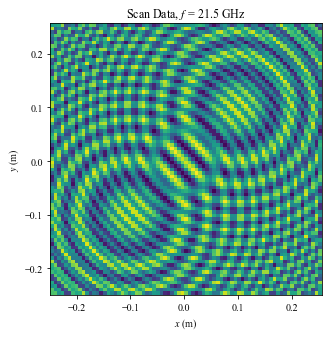

In [3]:
x_target = -0.1
y_target = -0.1
z_target = z_offset
target = np.array([x_target, y_target, z_target])[None,:]
target = np.concatenate((target, np.array([x_target+.2, y_target+.2, z_target])[None,:]), axis=0)

measurements = np.zeros((ya.size, xa.size, Nf), dtype=np.complex64)
for t in range(target.shape[0]):
    Rt = np.sqrt((Xa + d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    Rr = np.sqrt((Xa - d_antennas/2 - target[t,0])**2 + (Ya - target[t,1])**2 + (Za - target[t,2])**2)
    for kk in range(f.size):
        measurements[:,:,kk] += G(k[kk], Rt) * G(k[kk], Rr)

set_font(fontsize=15)
fig = plt.figure(figsize=(5,5))
plt.imshow(np.real(measurements[:,:,0]),
           extent=(np.amin(xa), np.amax(xa), np.amin(ya), np.amax(ya)),
           origin='lower')
plt.title('Scan Data, $f$ = {} GHz'.format(f[0]*1E-9))
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.show()

### Define reconstruction region

In [4]:
Lxs = .5
Lys = .5
Lzs = .5

cr_res_x = np.amin(lam)*z_offset/(2*Lxa)
cr_res_y = np.amin(lam)*z_offset/(2*Lya)
r_res_z = C/bw

delta_xs = cr_res_x/2
delta_ys = cr_res_y/2
delta_zs = r_res_z/2

xs_offset = 0
ys_offset = 0
zs_offset = 0

Nkx, Nky, Nkz = (int(4*np.amax(k) * Lxs / (2*np.pi)), 
                 int(4*np.amax(k) * Lys / (2*np.pi)), 
                 int(4*np.amax(k) * Lzs / (2*np.pi)))
Nx, Ny, Nz = (int(2*np.pi * Nkx / (4*np.amax(k) * delta_xs)), 
              int(2*np.pi * Nky / (4*np.amax(k) * delta_ys)), 
              int(2*np.pi * Nkz / (4*np.amax(k) * delta_zs)))
# Nkx, Nky, Nkz = (300, 300, 300)
# Nx, Ny, Nz = (200, 200, 10)
# delta_k = np.amax(k) - np.amin(k)
# Nkx, Nky, Nkz = (int(Lxs / delta_xa), 
#                  int(Lys / delta_ya), 
#                  int(Lzs * delta_k/np.pi))
# Nx, Ny, Nz = (int(Nkx * delta_xa/delta_xs), 
#               int(Nky * delta_ya/delta_ys), 
#               int(np.pi*Nkz / (delta_k * delta_zs)))

xs = np.arange(-np.floor(Nx/2), np.ceil(Nx/2)) * delta_xs + xs_offset
ys = np.arange(-np.floor(Ny/2), np.ceil(Ny/2)) * delta_ys + ys_offset
zs = np.arange(-np.floor(Nz/2), np.ceil(Nz/2)) * delta_zs + zs_offset
X, Y, Z = np.meshgrid(xs, ys, zs, indexing='xy')

### Reconstruct

In [5]:
pad_x = int((Lxs - Lxa) // delta_xa)
pad_y = int((Lys - Lya) // delta_ya)
measurements_pad = np.pad(measurements, ((pad_x//2, pad_x//2), (pad_y//2, pad_y//2), (0, 0)), mode='constant')
Nx_pad = measurements_pad.shape[1]
Ny_pad = measurements_pad.shape[0]
measurements_ft = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(
                        measurements_pad,
                        axes=(0,1)), axes=(0,1)), axes=(0,1))
delta_kx = 2*np.pi/(delta_xa * Nx_pad)
delta_ky = 2*np.pi/(delta_ya * Ny_pad)
kx = np.arange(-np.floor(Nx_pad/2), np.ceil(Nx_pad/2)) * delta_kx
ky = np.arange(-np.floor(Ny_pad/2), np.ceil(Ny_pad/2)) * delta_ky
Kx, Ky, K = np.meshgrid(kx.astype(np.complex64), ky.astype(np.complex64), k.astype(np.complex64), indexing='xy')
Kz = np.sqrt(4*K**2 - Kx**2 - Ky**2)
measurements_ft[np.imag(Kz)!=0] = 0
Kz[np.imag(Kz)!=0] = 0

filt = np.nan_to_num(K / Kz**2)
measurements_ft = measurements_ft * np.exp(1j * Kz * z_offset) / filt

In [6]:
NufftObj = NUFFT()
Jd = (3, 3, 3)

K_array = np.stack((np.real(Kx).flatten(), np.real(Ky).flatten(), np.real(Kz).flatten()), axis=1) * np.pi/(2*np.amax(k))   # normalizing to pi

measurements_reshape = measurements_ft.flatten()

NufftObj.plan(K_array, (Nx, Ny, Nz), (Nkx, Nky, Nkz), Jd)

im = NufftObj.adjoint(measurements_reshape)

### Plot

In [7]:
# im_2d = np.transpose(np.abs(np.mean(im, 2))**2, (1,0))
im_2d = np.transpose(np.abs(im[:,:,im.shape[2]//2])**2, (1,0))

N_interp = 3
im_interpolate = np.abs(fft_resample(im_2d, N_interp*im_2d.shape[0], N_interp*im_2d.shape[1]))
im_interpolate = 10*np.log10(im_interpolate/np.amax(im_interpolate))

%matplotlib qt
set_font(fontsize=15)
plt.figure()
plt.imshow(im_interpolate,
           extent=(np.amin(xs), np.amax(xs), np.amin(ys), np.amax(ys)),
           origin='lower')
plt.clim(-20, 0)
plt.xlabel('$x$ (m)')
plt.ylabel('$y$ (m)')
plt.title('Reconstruction')
plt.colorbar(label='dB')
plt.show()